### Общая информация

Работу выполнил Хисматуллин Владимир.

В данной работе исследуется зависимость распределения активация нейронной сети от гиперпараметров:

Глубина, ширина, skip-connect, Batch Norm, DropOut, инциализация, обрезание (clipping) активаций.

В отчёте почти нет кода - всё спрятано в модули exp_s (эксперименты) и utils (модель сети и вспомогательные функции).

Графики не векторные, так как с ними могут быть лаги.

Дисперсия, если выводить её как число на графиках, выглядит плохо, поэтому везде где пишется 'дисперсия высокая/низкая', имеется ввиду её определение 'на глаз'.

### Пара слов про DataSet'ы
Все данные стандартизированы. Для регрессионных моделей стандартизированы отклики, таким образом отклики сетей для разных задач сравнивать корректно.

Из sklearn toy взяты датасеты с достаточно большой выборкой: Информация о датасетах:

    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    << Name           |  Type     ||  Instances  ||  Features  >>
    <<--------------------------------------------------------->>
    << boston         |  REG      ||  506        ||  13        >>
    << breast_cancer  |  CLF, 2   ||  569        ||  30        >>
    << diabetes       |  REG      ||  442        ||  10        >>
    << digits         |  CLF, 10  ||  1797       ||  64        >>
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
Более подробно проанализируем их далее.

In [1]:
import numpy as np
import torch.nn as nn
from utils import get_dataloaders
train_boston, test_boston = get_dataloaders('boston', test_size=0.2, batch_size=100)
train_breast_cancer , test_breast_cancer = get_dataloaders('breast_cancer', test_size=0.2, batch_size=100)
train_diabetes , test_diabetes = get_dataloaders('diabetes', test_size=0.2, batch_size=100)
train_digits, test_digits = get_dataloaders('digits', test_size=0.2, batch_size=100)

In [2]:
import exp_s
from exp_s import plot_activation, exp_activations, exp_FFN

#### Отметим, чего нам хотелось бы от распределения активаций:
1. Симметричность на линейном слое.
2. Малая дисперсия.
3. Сохранение распределения при движении вглубь по слоям.

#### Про архитектуры сетей

Все сети строятся единым образом 

Вход (features) -> layer_1_linear -> BN_1 -> DO_1 -> activation_1 -> skip_connect_1 -> layer_2_linear -> ... -> activation_n
-> output_linear -> Выход

Причём все слои, кроме линейных и активаций, могут заменяться на identity layer , т.е. просто пропускать активации (являются таковыми по умолчанию). BN, DO, skip-connect в экспериментах используются, только если это оговорено.

В самих экспериментах будем обучать сети на разных датасетах и строить распределение активаций по слоям. В некоторых местах только после линейного слоя, в некоторых после слоя активаций.

Вдобавок будем выводить полученное качество, чтобы контролировать адекватность результатов.

### Эксперимент 1: функции активации

Вначале определимся с функцией активации, так как от неё зависит очень многое. Даже если она не входит в задание, не представляется возможным провести исследования без анализа зависимости распределений от неё.

Ниже для сети из 4 слоёв, все слои которой имеют ширину 40, на датасете diabetes проводится обучение модели, а далее снимаются активации на обучающей выборке. Также выводится качество предсказания на тестовой выборке.

Рассматриваются активации: ReLU, Tanh, Sigmoid, LeakyReLU, Hardshrink, GELU

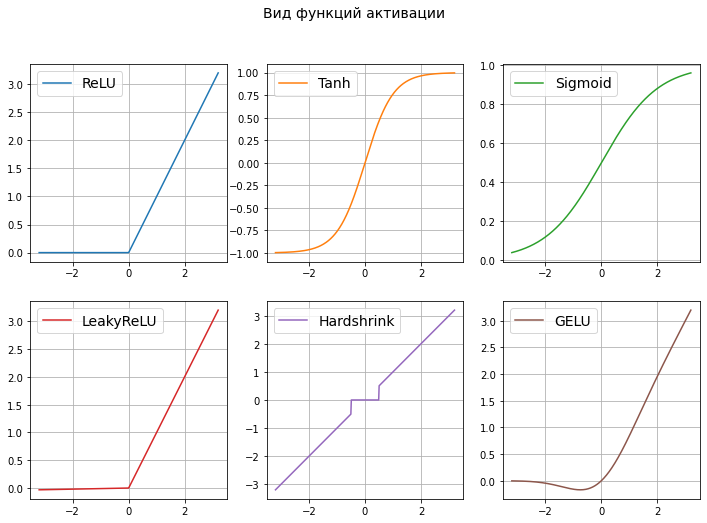

In [3]:
activation_list = [nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(), nn.Hardshrink(), nn.GELU()]
act_name_list = ['ReLU', 'Tanh', 'Sigmoid', 'LeakyReLU', 'Hardshrink', 'GELU']
plot_activation(activation_list, act_name_list)

ReLU MSE loss : 0.5336


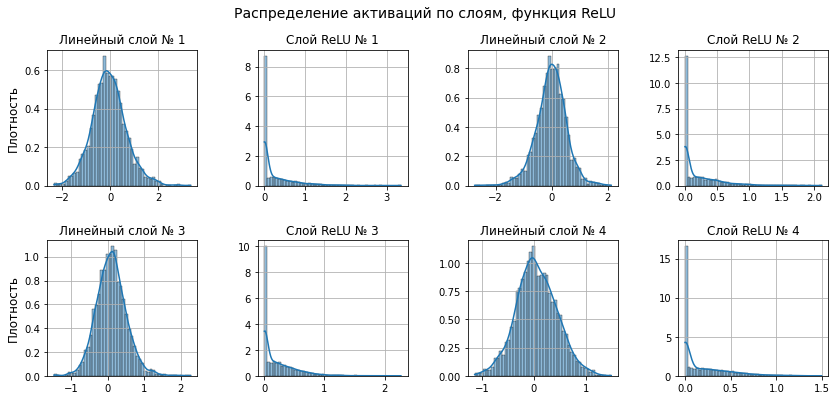

Tanh MSE loss : 0.5027


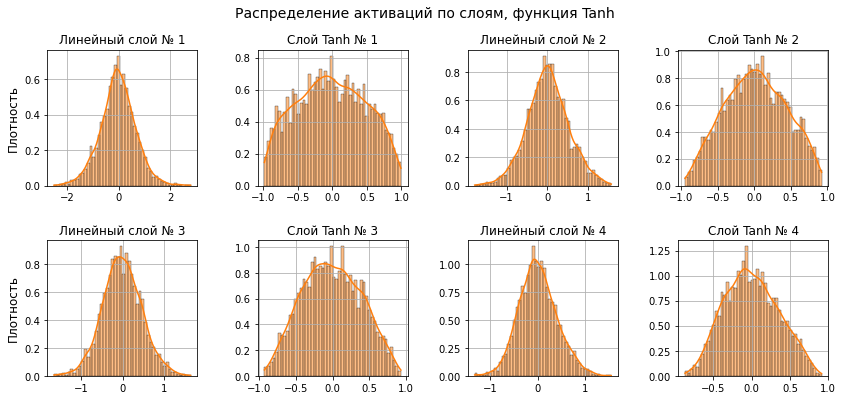

Sigmoid MSE loss : 0.9621


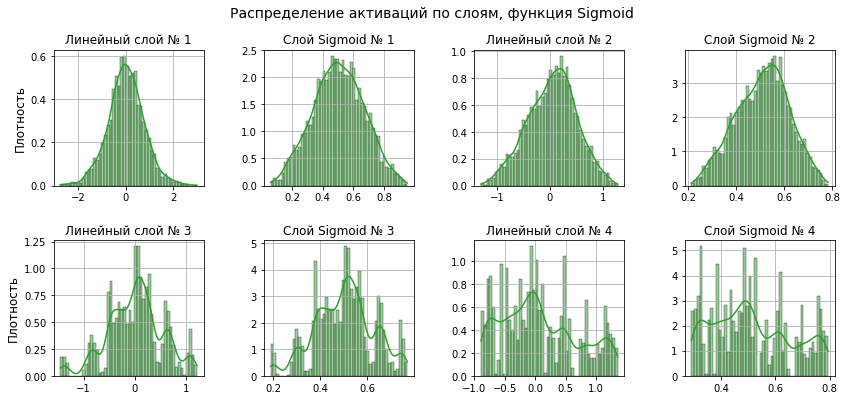

LeakyReLU MSE loss : 0.4428


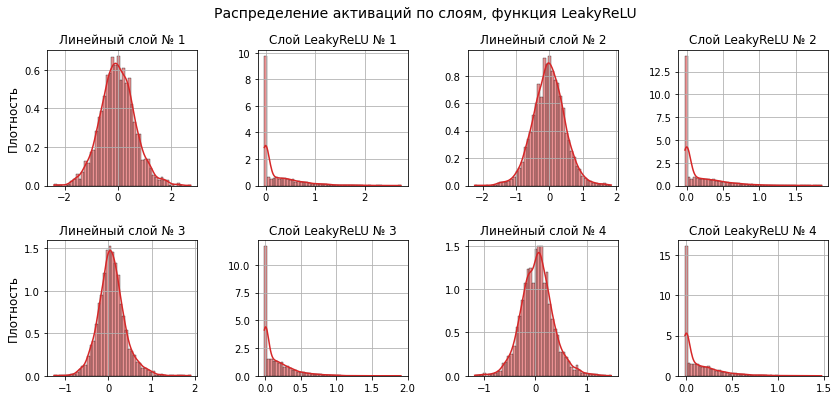

Hardshrink MSE loss : 0.6266


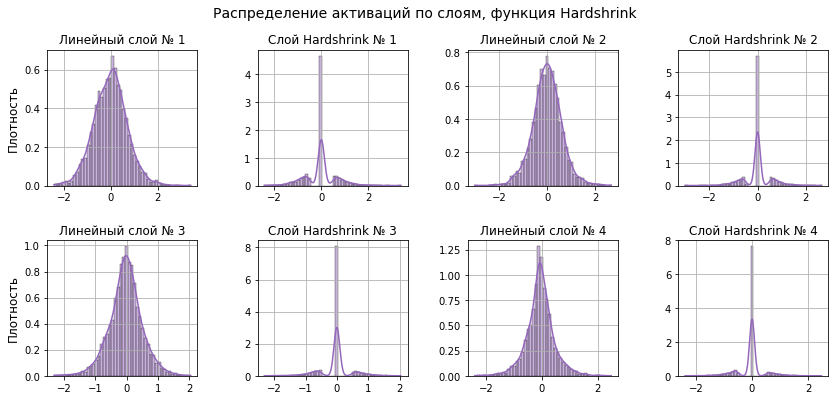

GELU MSE loss : 0.4645


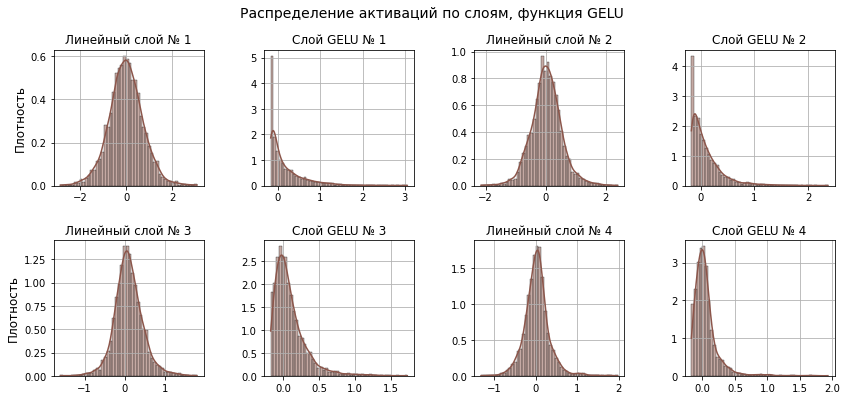

In [4]:
title_list = ['Распределение активаций по слоям, функция ' + act for act in act_name_list]
color = ['C' + str(i) for i in range(6)]
for i in range(6):
    exp_activations(train_diabetes, test_diabetes , activation_list[i], act_name_list[i], title_list[i], color[i])

На данных графиках, очевидно, побеждает GELU:

1. Tanh и Sigmoid нарушили симметричность, не сохранили распределение и повысили дисперсию.

2. ReLU, LeakyReLU не полностью сохранили нормальный вид, однако справились намного лучше предыдущих функций.

3. GELU и Hardshrink сохранили дисперсию, однако для GELU она чуть ниже.

Повторим процедуру для трёх лучших функций  на датасете классификации digits

LeakyReLU Cross Entropy loss : 0.2278


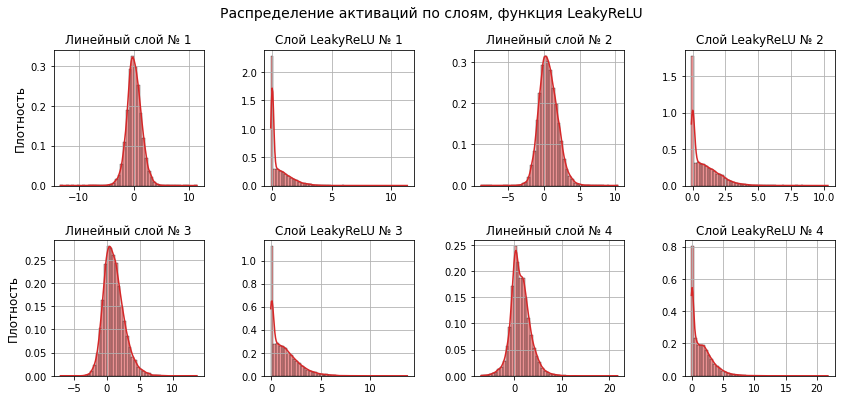

Hardshrink Cross Entropy loss : 0.3243


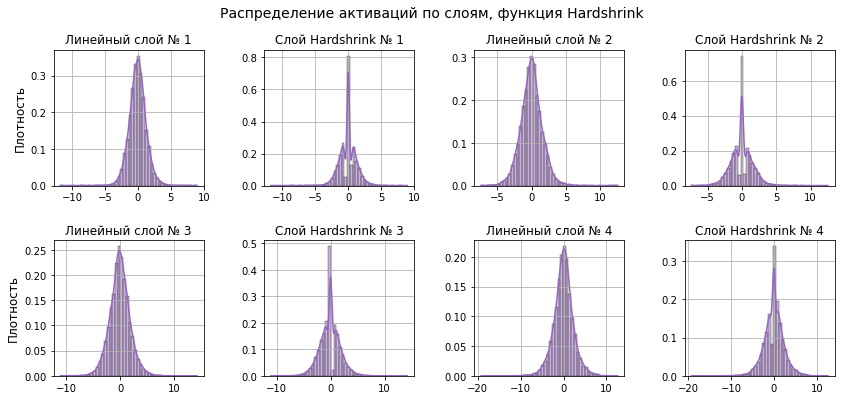

GELU Cross Entropy loss : 0.2182


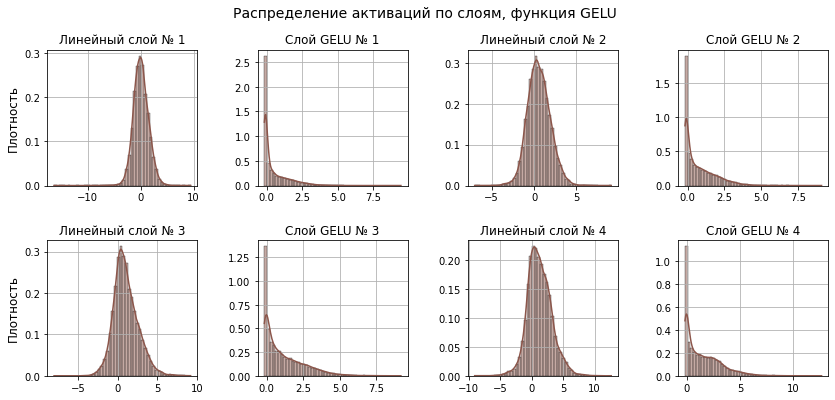

In [5]:
activation_list = [nn.LeakyReLU(), nn.Hardshrink(), nn.GELU()]
act_name_list = ['LeakyReLU', 'Hardshrink', 'GELU']
title_list = ['Распределение активаций по слоям, функция ' + act for act in act_name_list]
color = ['C' + str(i) for i in range(3, 6)]
for i in range(3):
    exp_activations(train_digits, test_digits, activation_list[i], act_name_list[i], title_list[i], color[i], n_classes=10)

В данном случае вновь побеждает GELU, с большим отрывом по качеству классификации и сохранению дисперсии. Поэтому далее будем использовать лишь её.

### Эксперимент №2: сети разной ширины для разных датасетов

Определимся с датасетом, для исследования сетей. Имеем две задачи регрессии и две - классификации. 

Будем обучать сети глубины 8 постоянной ширины (у таких сетей количество активаций на каждом внутреннем слое фиксировано). Будем варировать ширину и следить за изменением распределения активаций на линейном слое для разных данных. 



Сеть ширины 20 : MSE loss =  0.126
Сеть ширины 40 : MSE loss =  0.0953
Сеть ширины 80 : MSE loss =  0.0982
Сеть ширины 160 : MSE loss =  0.1156


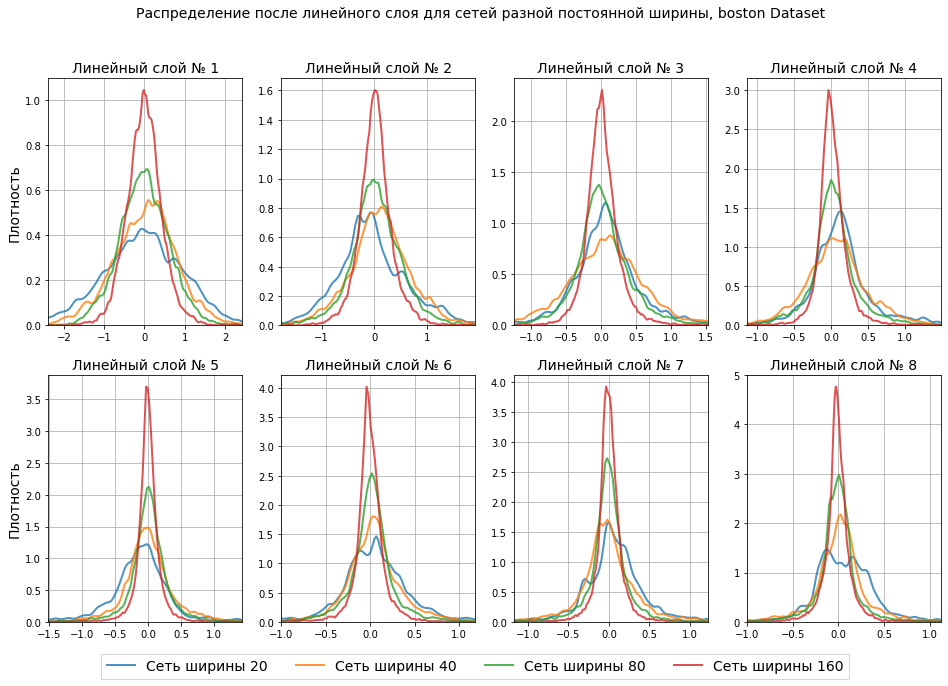

Сеть ширины 20 : MSE loss =  0.5005
Сеть ширины 40 : MSE loss =  0.4721
Сеть ширины 80 : MSE loss =  0.4959
Сеть ширины 160 : MSE loss =  0.4682


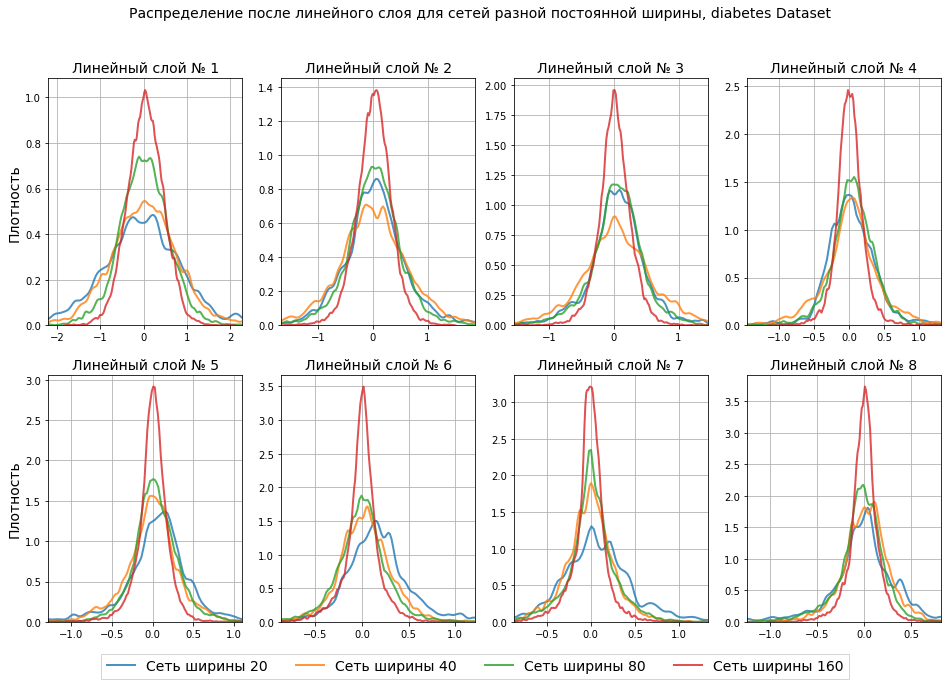

Сеть ширины 20 : Cross Entropy loss =  0.1734  : accuracy : 0.9474
Сеть ширины 40 : Cross Entropy loss =  0.3337  : accuracy : 0.9649
Сеть ширины 80 : Cross Entropy loss =  0.4654  : accuracy : 0.9825
Сеть ширины 160 : Cross Entropy loss =  0.4842  : accuracy : 0.9737


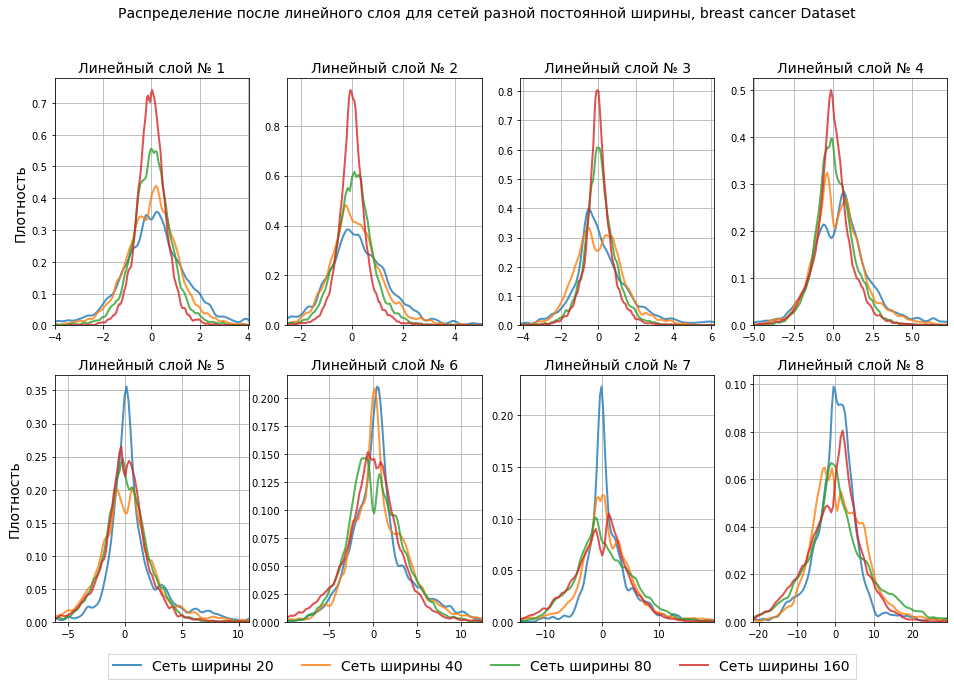

Сеть ширины 20 : Cross Entropy loss =  0.4955  : accuracy : 0.8583
Сеть ширины 40 : Cross Entropy loss =  0.222  : accuracy : 0.9472
Сеть ширины 80 : Cross Entropy loss =  0.3172  : accuracy : 0.9611
Сеть ширины 160 : Cross Entropy loss =  0.1242  : accuracy : 0.9750


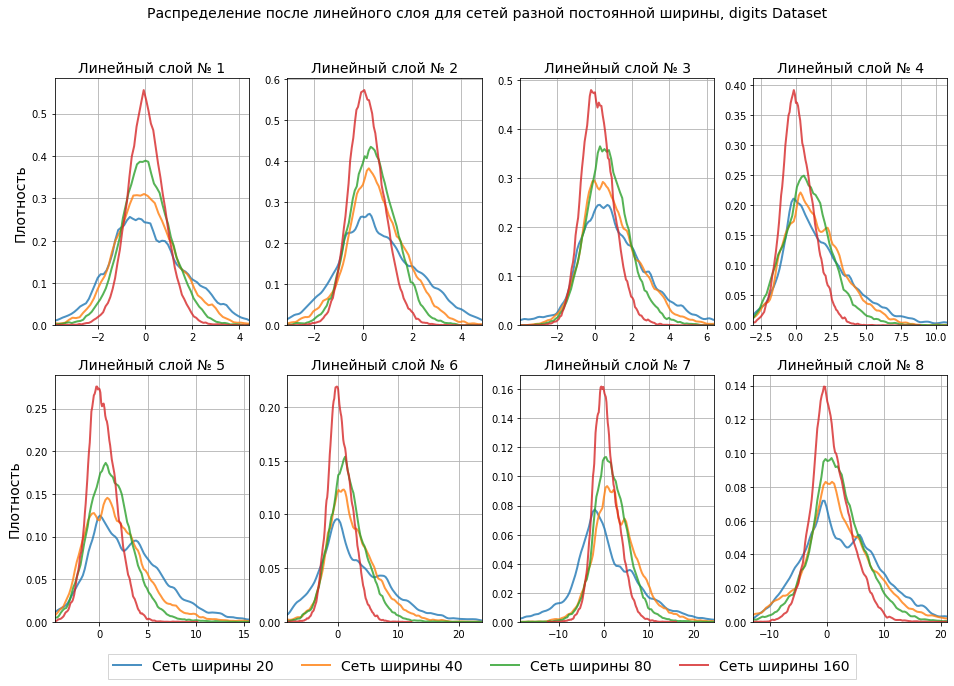

In [6]:
width_list = [20, 40, 80, 160]
model_strings = ['Сеть ширины {:}'.format(width) for width in width_list]

exp_s.exp_FFN(train_boston, test_boston,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, boston Dataset',
             model_strings=model_strings, n_models=4)

exp_s.exp_FFN(train_diabetes, test_diabetes,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, diabetes Dataset',
             model_strings=model_strings, n_models=4)

exp_s.exp_FFN(train_breast_cancer, test_breast_cancer,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, breast cancer Dataset',
             model_strings=model_strings, n_models=4, n_classes=2)

exp_s.exp_FFN(train_digits, test_digits,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, digits Dataset',
             model_strings=model_strings, n_models=4, n_classes=10)


Распределение для первых двух датасетов (boston и diabetes) почти одинаковые: у широких сетей дисперсия меньше, что вполне может объясняться тем, что большая часть весов модели не нужна, потому они не сильно 'расползаются'. В случае регрессии заметно уменьшение дисперсии с ростом слоя.

Отметим, что для ширины сети x, между соседними внутринними слоями модель будет иметь $x^2$ обучаемых параметров. Поэтому большая ширина в простых задачах - точно избыточна. 

Для задач классификации получен другой результат: дисперсия растёт очень быстро, причём для широких сетей она выше. Объяснить отличие можно тем, что распределение самих откликов связано с распределением активаций намного сложнее. 

Dataset digits намного больше других, а задача многоклассовой классификации сложнее регрессии, потому, вероятно, параметры используются более интесивно. Это могло бы объяснять наибольшую дисперсию на последних слоях среди датасетов. 

Возьмём далее в рассмотрение сложную задачу распрознования dataset'а digits и простую регрессию на примере boston.

---

Проведём ещё один эксперимент с шириной: рассмотрим модели с примерно одинаковым числом параметров, но с разной архитектурой:

Ширина первой сети постоянна, второй убывает , третьей возрастает, четвёртой - чередуется.

Обычная сеть : MSE loss =  0.0989
Bottleneck : MSE loss =  0.123
Reverse bottleneck : MSE loss =  0.1353
Сеть попеременной ширины : MSE loss =  0.1246


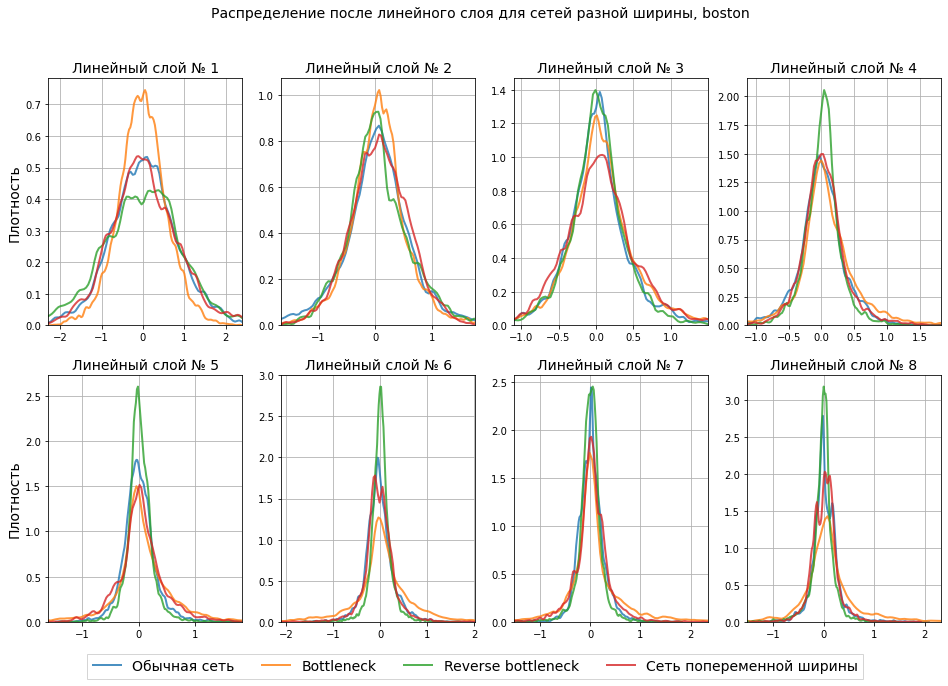

In [7]:
width_list = [
    (np.ones(8) * 40).astype(int), np.array(np.arange(20, 101, 10)[::-1]).astype(int), 
    np.arange(20, 101, 10).astype(int), (np.arange(8) % 2).astype(int) * 30 + 30 
]
model_strings = ['Обычная сеть', 'Bottleneck', 'Reverse bottleneck', 'Сеть попеременной ширины']
exp_s.exp_FFN(train_boston, test_boston,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной ширины, boston',
             model_strings=model_strings, n_models=4)

Обычная сеть : Cross Entropy loss =  0.1955  : accuracy : 0.9611
Bottleneck : Cross Entropy loss =  0.3303  : accuracy : 0.9694
Reverse bottleneck : Cross Entropy loss =  0.5279  : accuracy : 0.9111
Сеть попеременной ширины : Cross Entropy loss =  0.2925  : accuracy : 0.9250


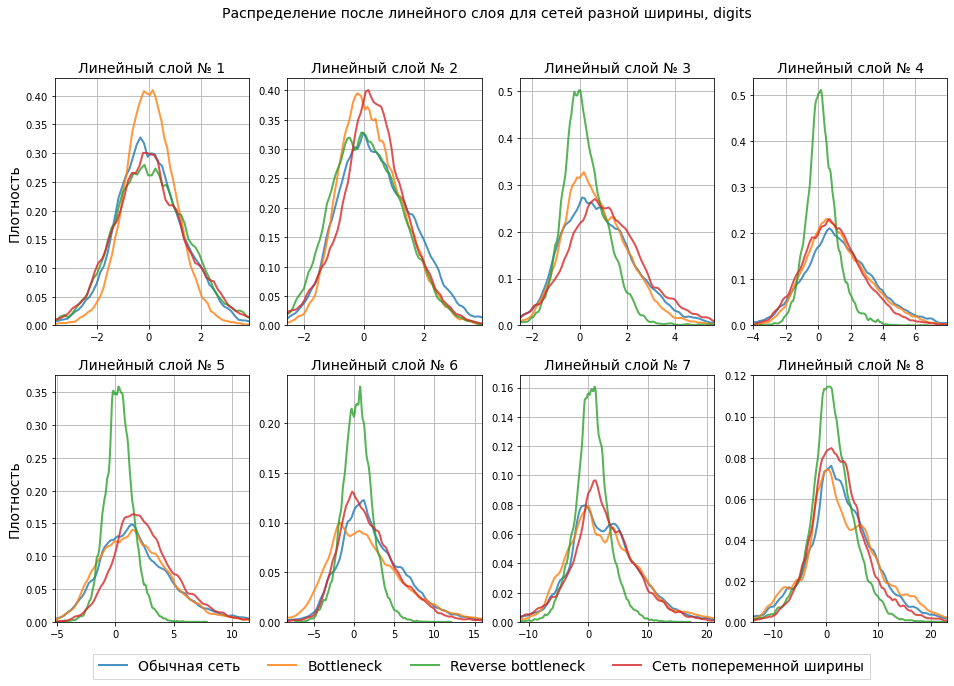

In [8]:
exp_s.exp_FFN(train_digits, test_digits,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной ширины, digits',
             model_strings=model_strings, n_models=4, n_classes=10)

Для всех моделей дисперсия по-прежнему возрастает, однако для reverse bottleneck сохраняется вид распределения. Причём в случае регресси для этой модели достигается наилучшее качество, а в случае классификации - худшее. Для bottleneck - наоборот, дисперсия наибольшая, качество в первом случае худшее, во втором - лучшее.

Возможно сохранение вида распределения всегда положительно влияет на качество в первом случае и отрицательно во втором. Проследим это далее. 

### Эксперимент №3: влияние BatchNorm

Рассмотрим распределения для сетей глубины 8, ширины 100. 

Графики построим для сети без BN, сети с двумя слоями BN, четырьмя и восьмью.

Без BN : MSE loss =  0.1418
BN после 2 и 6 слоя : MSE loss =  0.1614
BN после нечётного слоя : MSE loss =  0.21
BN после каждого слоя : MSE loss =  0.3589


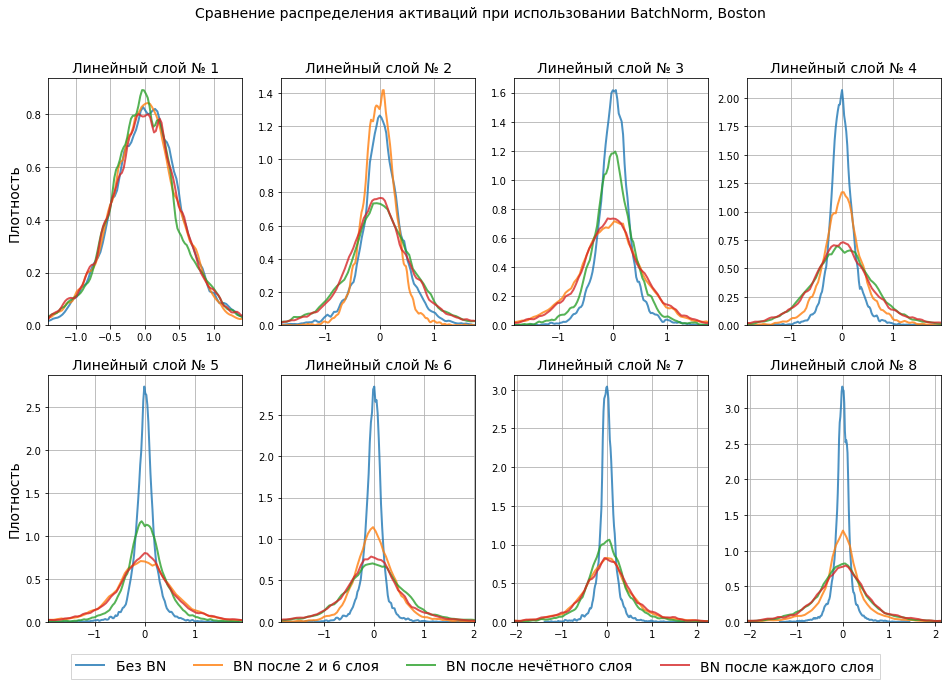

In [9]:
BN_list = [np.zeros(8), (np.arange(8) % 2 == 1).astype(int), 1 - np.arange(8) % 2, np.ones(8)]
model_strings = ['Без BN', 'BN после 2 и 6 слоя', 'BN после нечётного слоя',  'BN после каждого слоя']
title = 'Сравнение распределения активаций при использовании BatchNorm, Boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='linear', BN_list=BN_list)

Без BN : Cross Entropy loss =  0.3605  : accuracy : 0.9639
BN после 2 и 6 слоя : Cross Entropy loss =  0.1555  : accuracy : 0.9667
BN после нечётного слоя : Cross Entropy loss =  0.1905  : accuracy : 0.9500
BN после каждого слоя : Cross Entropy loss =  0.2159  : accuracy : 0.9472


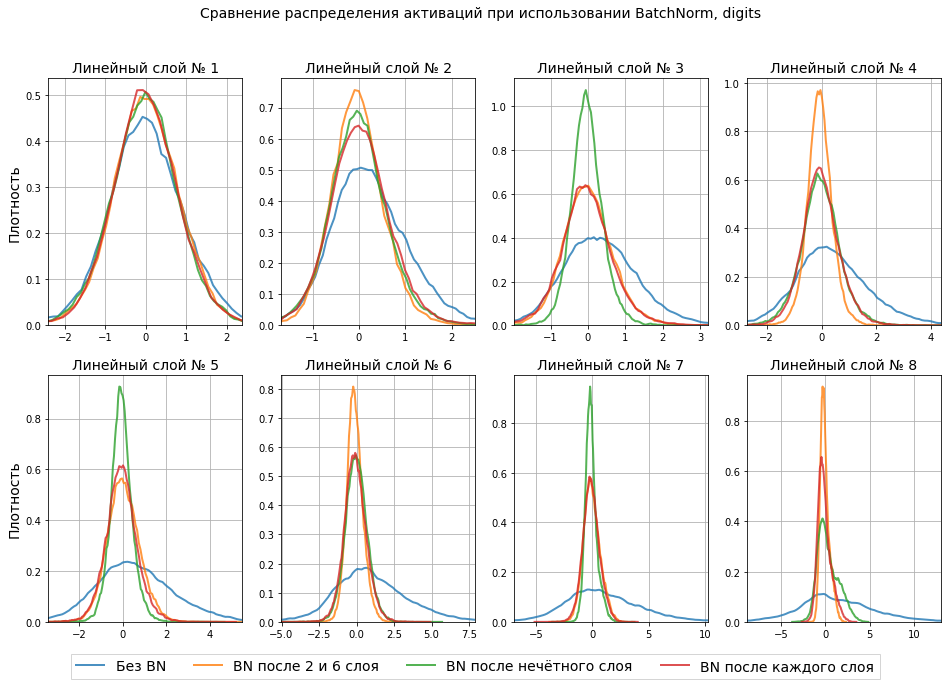

In [10]:
title = 'Сравнение распределения активаций при использовании BatchNorm, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='linear', BN_list=BN_list, n_classes=10)

BN в задаче регрессии привёл к повышению дисперсии, а в задаче классификации - наоборот. Ничего удивительного в этом нет, так как слой приводит признаки к единичной дисперсии. В первом случае мы изначально имели очень малую дисперсию, а во втором большую. 

На симметрию BN влияет положительно: при его использовании среднее почти не сдвигается. Причём лучше использовать относительно немного слоёв, чем вставлять BN всюду, куда можно.

В данном случае в задаче регрессии вновь лучше работают сети с малой дисперсией (без BN). Однако в задаче классификации ситуация изменилась: сеть с двумя слоями BN показала лучшее качество и имеет наименьшую дисперсию.

### Эксперимент №4: влияние Dropout

Рассмотрим распределения для всё тех же сетей глубины 8, ширины 100. 

Графики построим для сети без DO, с DO после нечётных слоёв (p=0.25), с DO после нечётных слоёв (p=0.5), 
с DO после всех слоёв (p=0.25)

Без DO : MSE loss =  0.1117
DO после нечётного слоя (p=0.05) : MSE loss =  0.1206
DO после нечётного слоя (p=0.2) : MSE loss =  0.1754
DO после каждого слоя : MSE loss =  0.1493


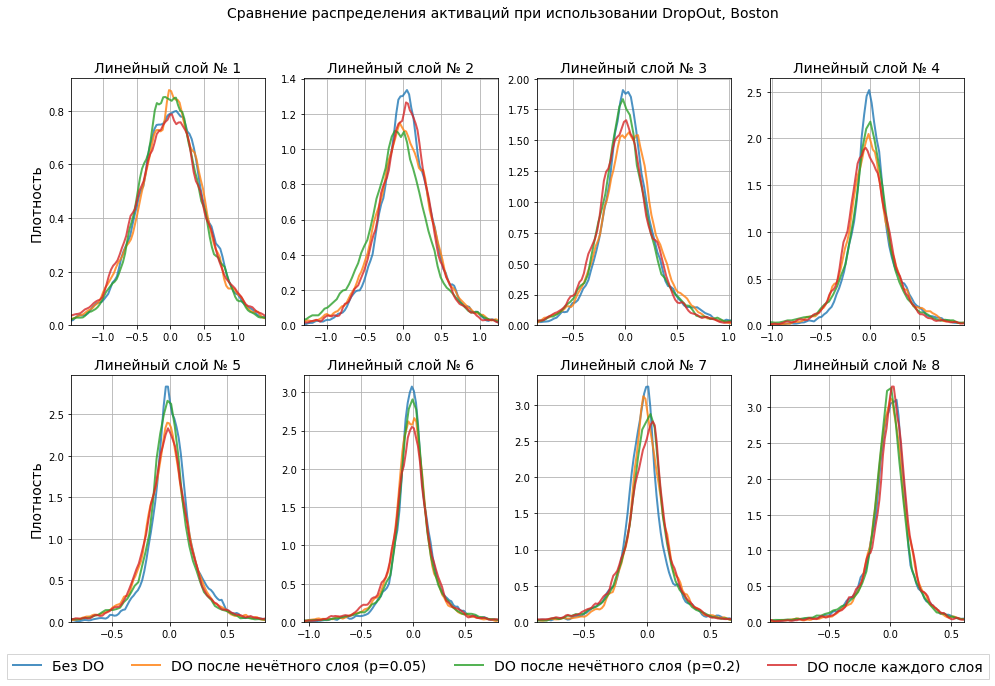

In [11]:
DO_list = [np.zeros(8), (1 - np.arange(8) % 2) * 0.1, (1 - np.arange(8) % 2) * 0.4, np.ones(8) * 0.1]
model_strings = ['Без DO', 'DO после нечётного слоя (p=0.05)' , 'DO после нечётного слоя (p=0.2)', 'DO после каждого слоя']
title = 'Сравнение распределения активаций при использовании DropOut, Boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='linear', DO_list=DO_list)

Без DO : Cross Entropy loss =  0.2266  : accuracy : 0.9722
DO после нечётного слоя (p=0.05) : Cross Entropy loss =  0.2345  : accuracy : 0.9667
DO после нечётного слоя (p=0.2) : Cross Entropy loss =  0.3549  : accuracy : 0.8889
DO после каждого слоя : Cross Entropy loss =  0.2697  : accuracy : 0.9528


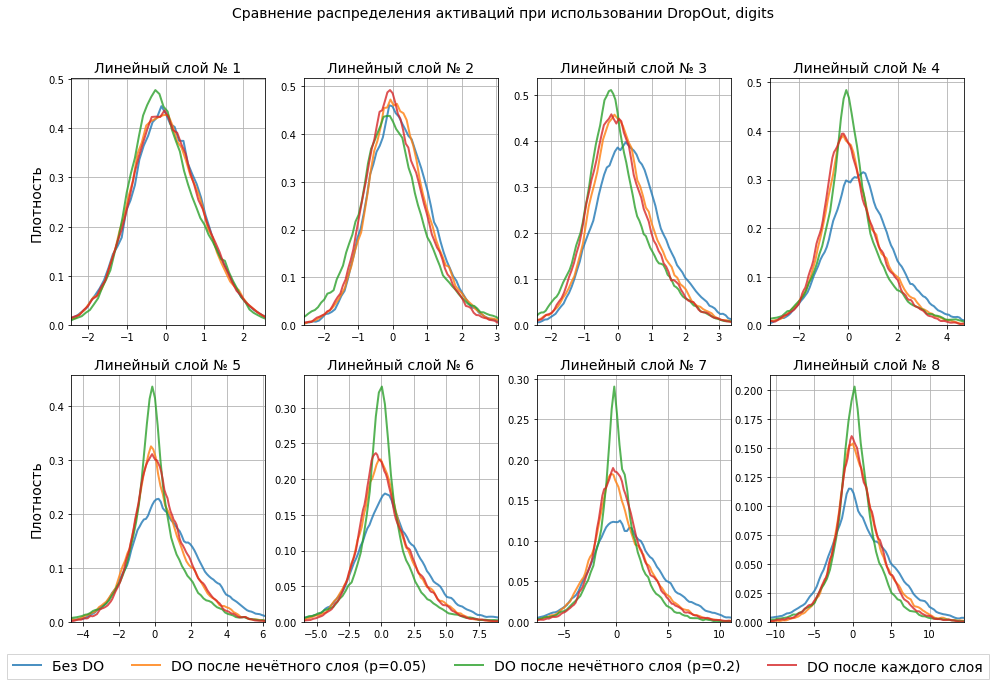

In [12]:
title = 'Сравнение распределения активаций при использовании DropOut, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='linear', DO_list=DO_list, n_classes=10)

Результаты для разных данных снова разные:

Для простой задачи DropOut принёс незначительные изменения в распределение активаций.

Для сложной задачи более сильный DropOut (после каждого слоя и после нечётного с $p=0.2$) имеет чуть меньшую дисперсию, однако ценой качества. 

Можно заключить, что для простых моделей DropOut излишен, а для сложных хорошо борется с ростом дисперсии и сохраняет распределение активаций.

### Эксперимент №5: влияние инициализации

Рассмотрим пять инициализаций:

Xavier и kaiming в двух формах: Uniform и Normal, а также равномерное распределение на отрезке \[0,0.001\]

Xavier uniform : MSE loss =  0.1112
Kaiming uniform : MSE loss =  0.1119
Xavier normal : MSE loss =  0.1071
Kaiming normal : MSE loss =  0.1147
Uniform [0, 0.001] : MSE loss =  0.1475


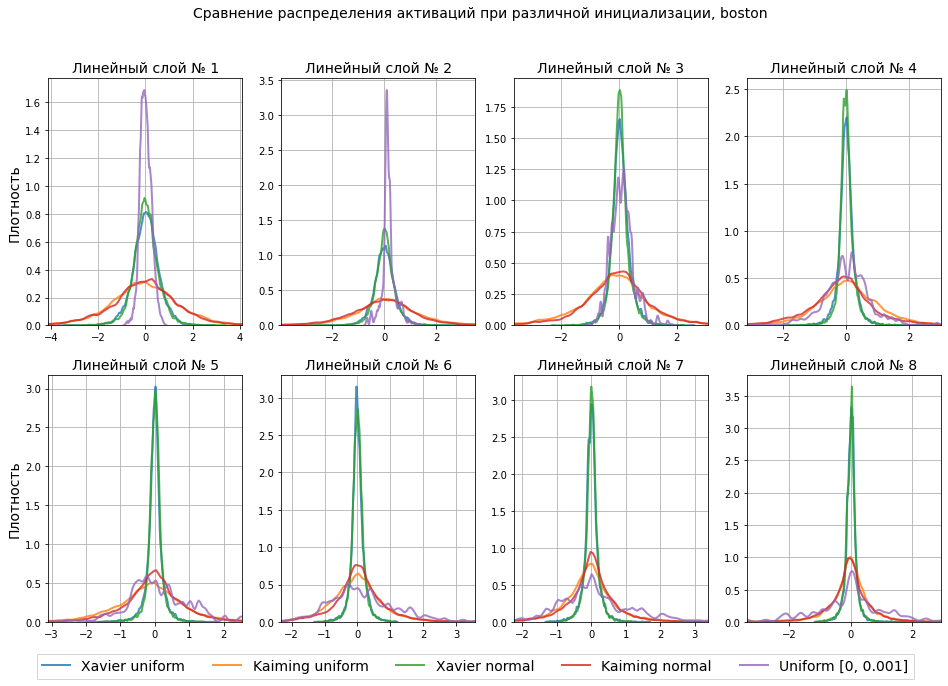

In [13]:
inits = [nn.init.xavier_uniform_, nn.init.kaiming_uniform_, nn.init.xavier_normal_, 
         nn.init.kaiming_normal_, nn.init.uniform_]
kwargs_list = [{}, {}, {}, {}, {'a':0, 'b':0.001}]
init_lists = [[(init_, kwargs_list[i])] * (8 + 1) for i ,init_ in enumerate(inits)]
title = 'Сравнение распределения активаций при различной инициализации, boston'
model_strings =  ['Xavier uniform', 'Kaiming uniform', 'Xavier normal', 'Kaiming normal', 'Uniform [0, 0.001]']
exp_FFN(train_boston, test_boston, title, model_strings, n_models=5, mode='linear', init_lists=init_lists)

Xavier uniform : Cross Entropy loss =  0.2714  : accuracy : 0.9583
Kaiming uniform : Cross Entropy loss =  0.3035  : accuracy : 0.9639
Xavier normal : Cross Entropy loss =  0.1757  : accuracy : 0.9694
Kaiming normal : Cross Entropy loss =  0.3049  : accuracy : 0.9500
Uniform [0, 0.001] : Cross Entropy loss =  1.1314  : accuracy : 0.5333


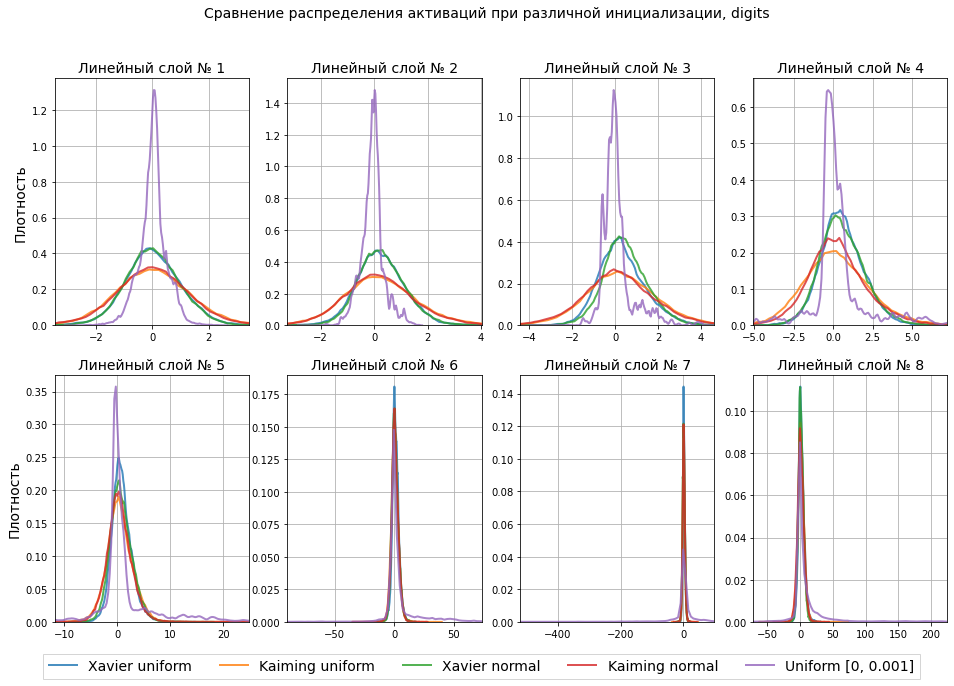

In [14]:
title = 'Сравнение распределения активаций при различной инициализации, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=5, mode='linear', 
        init_lists=init_lists, n_classes=10)

В случае boston инициализация имела значительный эффект: Xavier удерживает дисперсию с ростом номера слоя, сеть хорошо обучается. Kaiming имеет бОльшую дисперсию с самого начала, но не сильно расползается. Равномерное распределение имеет большой хвост и является плохой инциализацией.

В случае digits все инициализации приводят к постепенному увеличению дисперсии, но хуже всего работает равномерное на $[0,0.001]$ инициализация. Последняя имеет лучшую дисперсию вначале, но быстро теряет форму, причём качество на тестовой выборке получается убедительно плохим. 

### Эксперимент №6: влияние skip-connect

Поясню обозначения для следующего эксперимента:

No skip - не используется skip-connect.

skip features - после каждого слоя к выходам конкатенируем исходные признаки.

single skip - прокидываем активации с прошлого слоя.

double skip - прокидываем активации с двух слоёв назад.

No skip : MSE loss =  0.1307
skip features : MSE loss =  0.0912
double skip : MSE loss =  0.0948
single skip : MSE loss =  0.0891


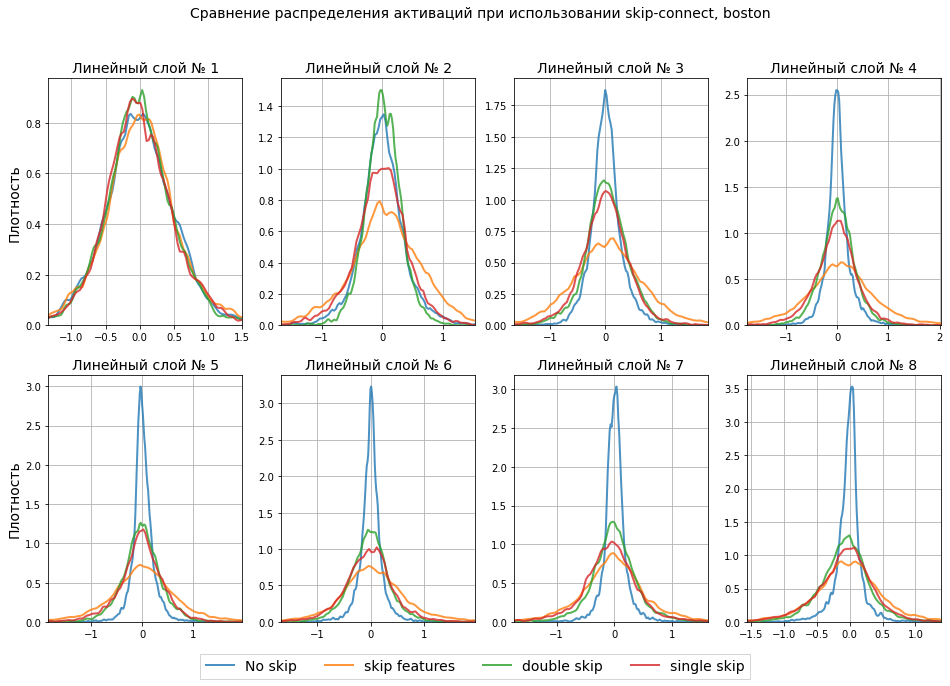

In [15]:
skip_list = [np.zeros(9, dtype= int)-1, np.zeros(9, dtype= int), np.arange(9, dtype= int)-2, np.arange(9, dtype= int)-1]
title = 'Сравнение распределения активаций при использовании skip-connect, boston'
model_strings =  ['No skip', 'skip features', 'double skip', 'single skip']
exp_FFN(train_boston, test_boston, title , model_strings, 
        n_models=4, mode='linear', skip_list=skip_list)

No skip : Cross Entropy loss =  0.2037  : accuracy : 0.9556
skip features : Cross Entropy loss =  0.0937  : accuracy : 0.9833
double skip : Cross Entropy loss =  0.1815  : accuracy : 0.9778
single skip : Cross Entropy loss =  0.204  : accuracy : 0.9778


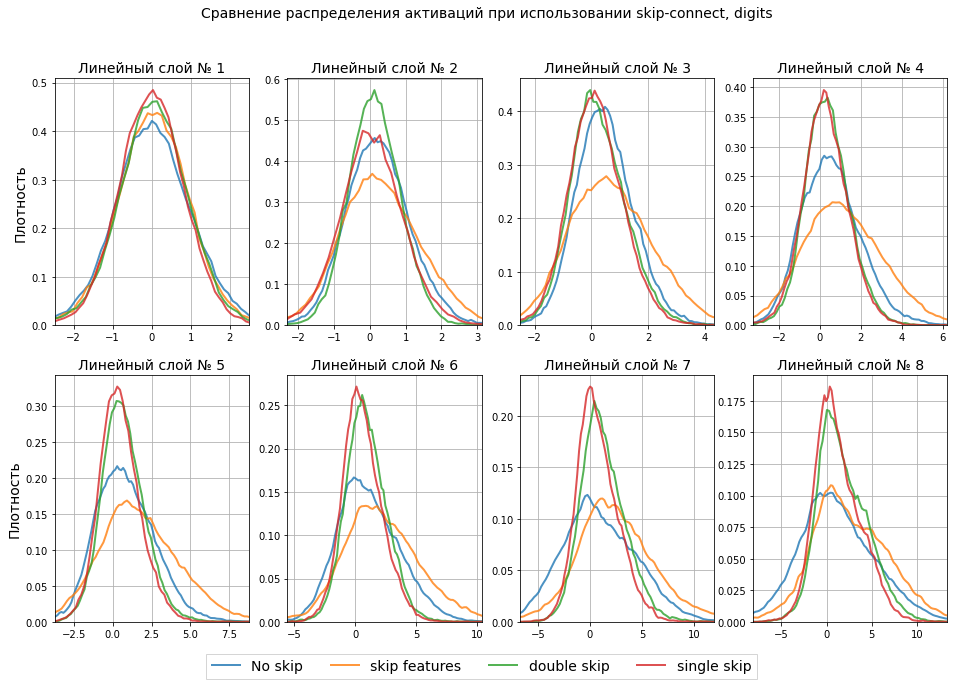

In [16]:
title = 'Сравнение распределения активаций при использовании skip-connect, digits'
exp_FFN(train_digits, test_digits, title, model_strings, 
        n_models=4, mode='linear', skip_list=skip_list, n_classes=10)

Для прсотой задачи skip-connect сохранил, но не улучшил вид распределения. Качество при этом улучшилось.

В случае сложной, double skip и single skip сохранили вид распределения и замедлили рост дисперсии. Также значительно улучшилось качество.

### Эксперимент №7: clipping активаций

Под клиппингом активаций можно понимать ограничение функции активации сверху.

Пример такой хорошо известной функции - $\text{ReLU6}$

$$
\text{ReLU6}(x) = \begin{cases}
    \text{ReLU}(x) & \text{if } \text{ReLU}(x) < 6 \\ % & is your "\tab"-like command (it's a tab alignment character)
    6 & \text{otherwise.}
\end{cases}
$$

Аналогично определим $\text{GELU}(\theta)$

$$
\text{GELU}(\theta)(x) = \begin{cases}
    \text{GELU}(x) & \text{if } \text{GELU}(x) < \theta \\ % & is your "\tab"-like command (it's a tab alignment character)
    \theta & \text{otherwise.}
\end{cases}
$$

Для задачи регрессии выставим пороги $\theta = $ 0.1, 0.3, 0.6, 1

Для задачи классификации: 0.5, 1, 3, 5

GELU(0.1) : MSE loss =  0.1142
GELU(0.3) : MSE loss =  0.1197
GELU(0.6) : MSE loss =  0.1043
GELU(1.0) : MSE loss =  0.0961


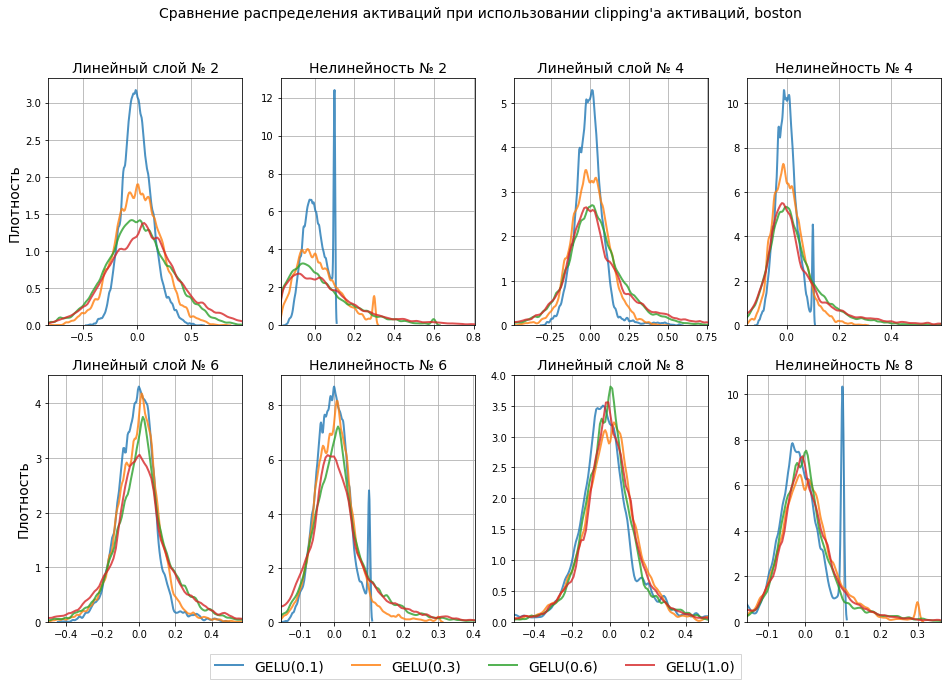

In [17]:
clip_list = [0.1, 0.3, 0.6, 1]
model_strings =  ['GELU({:.1f})'.format(x) for x in clip_list]
title = 'Сравнение распределения активаций при использовании clipping\'а активаций, boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='both', clip_list=clip_list)

GELU(0.5) : Cross Entropy loss =  0.1373  : accuracy : 0.9639
GELU(1.0) : Cross Entropy loss =  0.1564  : accuracy : 0.9639
GELU(3.0) : Cross Entropy loss =  0.1041  : accuracy : 0.9778
GELU(5.0) : Cross Entropy loss =  0.24  : accuracy : 0.9556


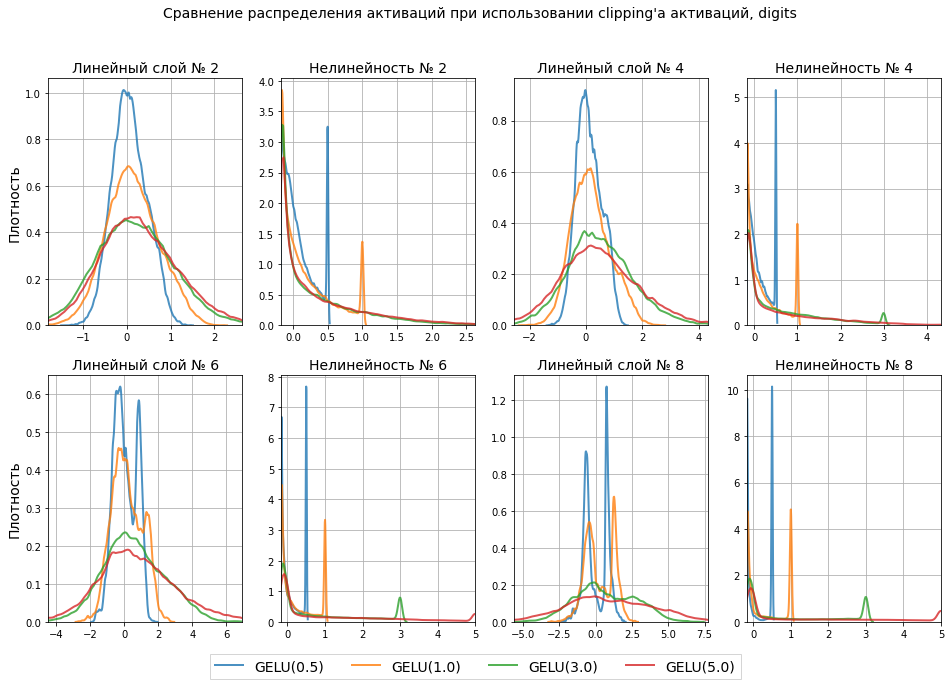

In [18]:
clip_list = [0.5, 1, 3, 5]
model_strings =  ['GELU({:.1f})'.format(x) for x in clip_list]
title = 'Сравнение распределения активаций при использовании clipping\'а активаций, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='both', clip_list=clip_list, n_classes=10)

Заметно, что обрезание всюду сильно сокращает дисперсию, но значительно меняет вид распределения. Есть некоторый trade-off между сокращением дисперсии и изменением вида распределения. Данный эффект намного сильнее выражен на примере второй задачи.

### Финальный эксперимент

Используем лучшие параметры, полученные на каждом этапе для digits, для данного датасета и аналогичной задачи - breast_cancer.

Базовая сеть : Cross Entropy loss =  0.3748  : accuracy : 0.9667
Лучшие параметры : Cross Entropy loss =  0.0966  : accuracy : 0.9806


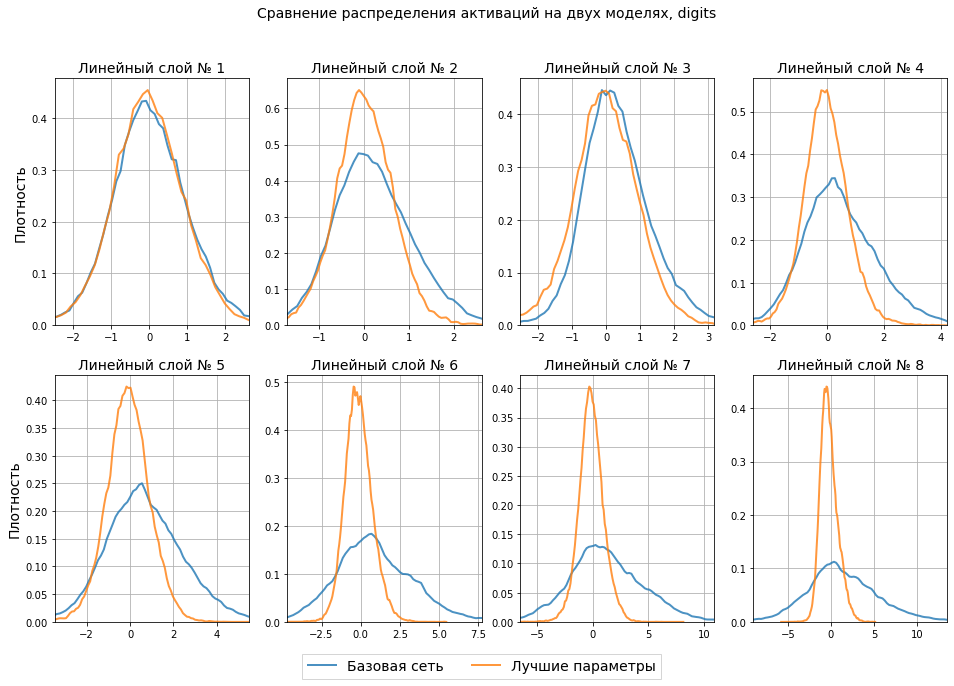

In [21]:
width_list = [
    (np.ones(8) * 100).astype(int),
    np.arange(60, 131, 10).astype(int)
]
clip_list = [None, 5]

BN = [np.zeros(8), (np.arange(8) % 2 == 1).astype(int)]
DO = [np.zeros(8), np.ones(8) * 0.1]
skip_list = [np.zeros(9, dtype= int)-1, np.arange(9, dtype= int)-2]
model_strings =  ['Базовая сеть', 'Лучшие параметры']
title = 'Сравнение распределения активаций на двух моделях, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=2, mode='linear', width=width_list,
        clip_list=clip_list, BN_list=BN, DO_list=DO, skip_list=skip_list, n_classes=10)

Базовая сеть : Cross Entropy loss =  0.3012  : accuracy : 0.9737
Лучшие параметры : Cross Entropy loss =  0.1175  : accuracy : 0.9649


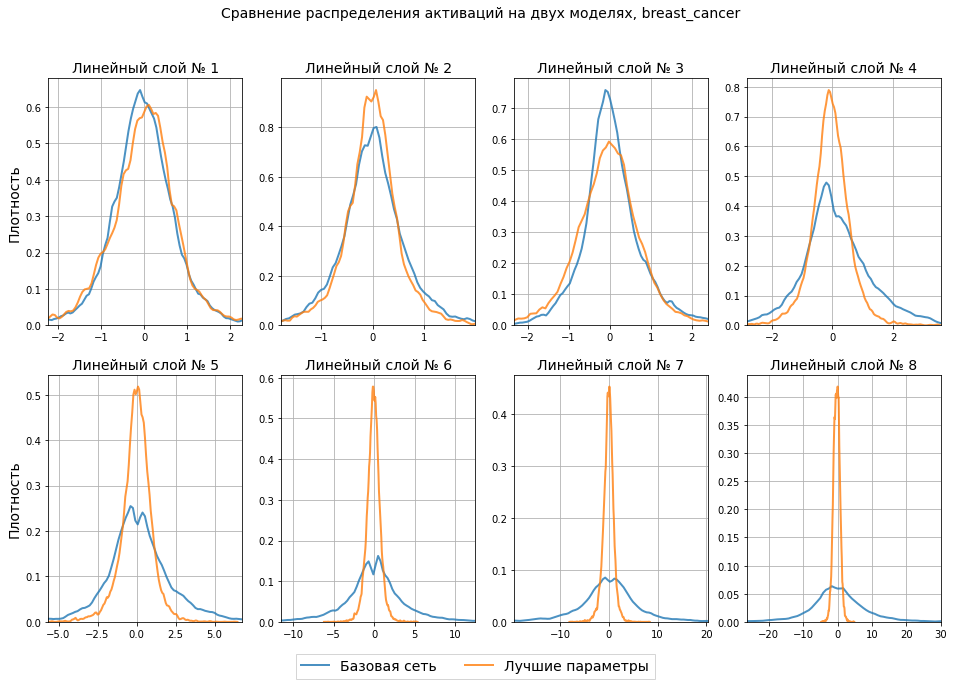

In [22]:
title = 'Сравнение распределения активаций на двух моделях, breast_cancer'
exp_FFN(train_breast_cancer, test_breast_cancer, title, model_strings, n_models=2, mode='linear', width=width_list,
        clip_list=clip_list, BN_list=BN, DO_list=DO, skip_list=skip_list, n_classes=2)

Распределение отлично сохранилось, дисперсия выросла совсем немного. Поэтому исследование можно признать удачным.